In [2]:
import pandas as pd
import numpy as np
import re
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
# from sklearn_extra.cluster import KMedoids
from sklearn.manifold import Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import copy
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_df(df, max_height, num_rows):
    """Displays a DataFrame in a scrollable format in the VS Code Python Interactive Window.

    Args:
        df: The pandas DataFrame to display.
        max_height: The maximum height of the scrollable area in pixels.
        num_rows: The number of rows to display before truncating.
    """

    from IPython.display import HTML
    import pandas as pd

    # Truncate the DataFrame to the specified number of rows
    df = df.head(num_rows)

    # Convert the DataFrame to HTML
    html_string = df.to_html()

    # Create an HTML table with scrolling
    html_table = f"<div style='overflow-x:auto; overflow-y:auto; max-height:{max_height}px;'>{html_string}</div>"

    # Display the HTML table
    display(HTML(html_table))

### Preprocessing data

In [4]:
# Load pre-extracted feature data
data = pd.read_csv('data/HR_data_2.csv')
data = data.drop(columns=['Unnamed: 0'])

In [5]:
# Create a new columns according to data description

cohort_session = {
    'D1_1': 'D11', 
    'D1_2': 'D12', 
    'D1_3': 'D13', 
    'D1_4': 'D13', 
    'D1_5': 'D13', 
    'D1_6': 'D13', 
}

data['Session'] = data['Cohort'].map(cohort_session)

cohort_time_of_day = {
    'D1_1': 'Unknown',
    'D1_2': 'Unknown',
    'D1_3': 'Morning',
    'D1_4': 'Evening',
    'D1_5': 'Morning',
    'D1_6': 'Evening',
}

data['TimeofDay'] = data['Cohort'].map(cohort_time_of_day)

cohort_season = {
    'D1_1': 'Winter', 
    'D1_2': 'Fall',
    'D1_3': 'Fall', 
    'D1_4': 'Fall', 
    'D1_5': 'Fall', 
    'D1_6': 'Fall', 
}

data['Season'] = data['Cohort'].map(cohort_season)

In [6]:
data.shape

(312, 73)

In [7]:
display_df(data, 73, 312)

In [8]:
# Count NaN values per row
nan_counts = data.isna().sum(axis = 1)

# Show which rows contains NaN and how many
rows_with_nans_df = (nan_counts[nan_counts > 0].rename("num_nans").to_frame())
print(rows_with_nans_df)

     num_nans
104         4
120         1
122         1
125         1
272         2


In [52]:
# Drop the rows with NaN values
data.dropna(inplace=True)

In [53]:
# Verify there are no more NaN values
print(data.isna().sum().sum())

0


In [54]:
# Define different types of features
numerical_data = copy.copy(data.iloc[:,0:51])

categories = ['Round','Phase','Cohort', 'Team_ID','Individual','Puzzler', 'Session', 'TimeofDay', 'Season']
categorical_data = copy.copy(data[categories])

ratings = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active']
rating_data = copy.copy(data[ratings])

In [55]:
# Flip negative columns (this way, higher number -> positive semantic meaning)
pos_list = ['inspired', 'attentive', 'active', 'determined']
target_emotion = ['Frustrated']

# now your flip loop can remain exactly as-is:
new_columns = {}
for col in rating_data.columns:
    if col in target_emotion:
        rating_data[col] = rating_data[col] / 2
    if col not in pos_list:
        print(f'{col} is flipped')
        new_columns[col] = col + '_flip'
        rating_data[col] = 5 - rating_data[col]
rating_data.rename(columns = new_columns, inplace = True)

Frustrated is flipped
upset is flipped
hostile is flipped
alert is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


In [56]:
# Drop the raw_data_path column before one-hot-encoding
#data = data.drop(columns = ['raw_data_path'])

In [57]:
# One-hot-encoding
encoded_data = pd.get_dummies(categorical_data, columns = categories, drop_first = True)

In [58]:
encoded_data = pd.concat([numerical_data, rating_data, encoded_data], axis = 1)

In [59]:
encoded_data.shape

(307, 115)

In [60]:
display_df(encoded_data, 115, 307)

In [9]:
# Standardize the numerical data
scaler = StandardScaler()
standard_array = scaler.fit_transform(encoded_data)
# Convert back to dataframe
standard_data = pd.DataFrame(standard_array, columns = encoded_data.columns, index = encoded_data.index)

display_df(standard_data, 115, 307)

NameError: name 'encoded_data' is not defined

### Explore clustering methods to derive insights from the data

Individual: a single global identifier that consistently labels each person across all cohorts
original_ID: the participant’s ID as it appeared in the cohort-specific ID

Based on these descriptions is possible to map from any feature-row back to its cohort-relative record by matching original_ID and raw_data_path, while doing all your analyses with the de-duplicated Individual field to ensure each person is only counted once.

However, the raw_data_path is currently not in the dataset, as this would make a mess when applying one-hot-encoding

In [62]:
# Try for clustering without 'Individual'
#categories.remove('Individual')

### Isomap (Isometric Mapping) 
It is a nonlinear dimensionality-reduction technique—part of the “manifold learning” family—that seeks a low-dimensional embedding of high-dimensional data while preserving the intrinsic geometry of the data manifold. It extends classical Multidimensional Scaling (MDS) by replacing Euclidean distances with geodesic (manifold-based) distances.

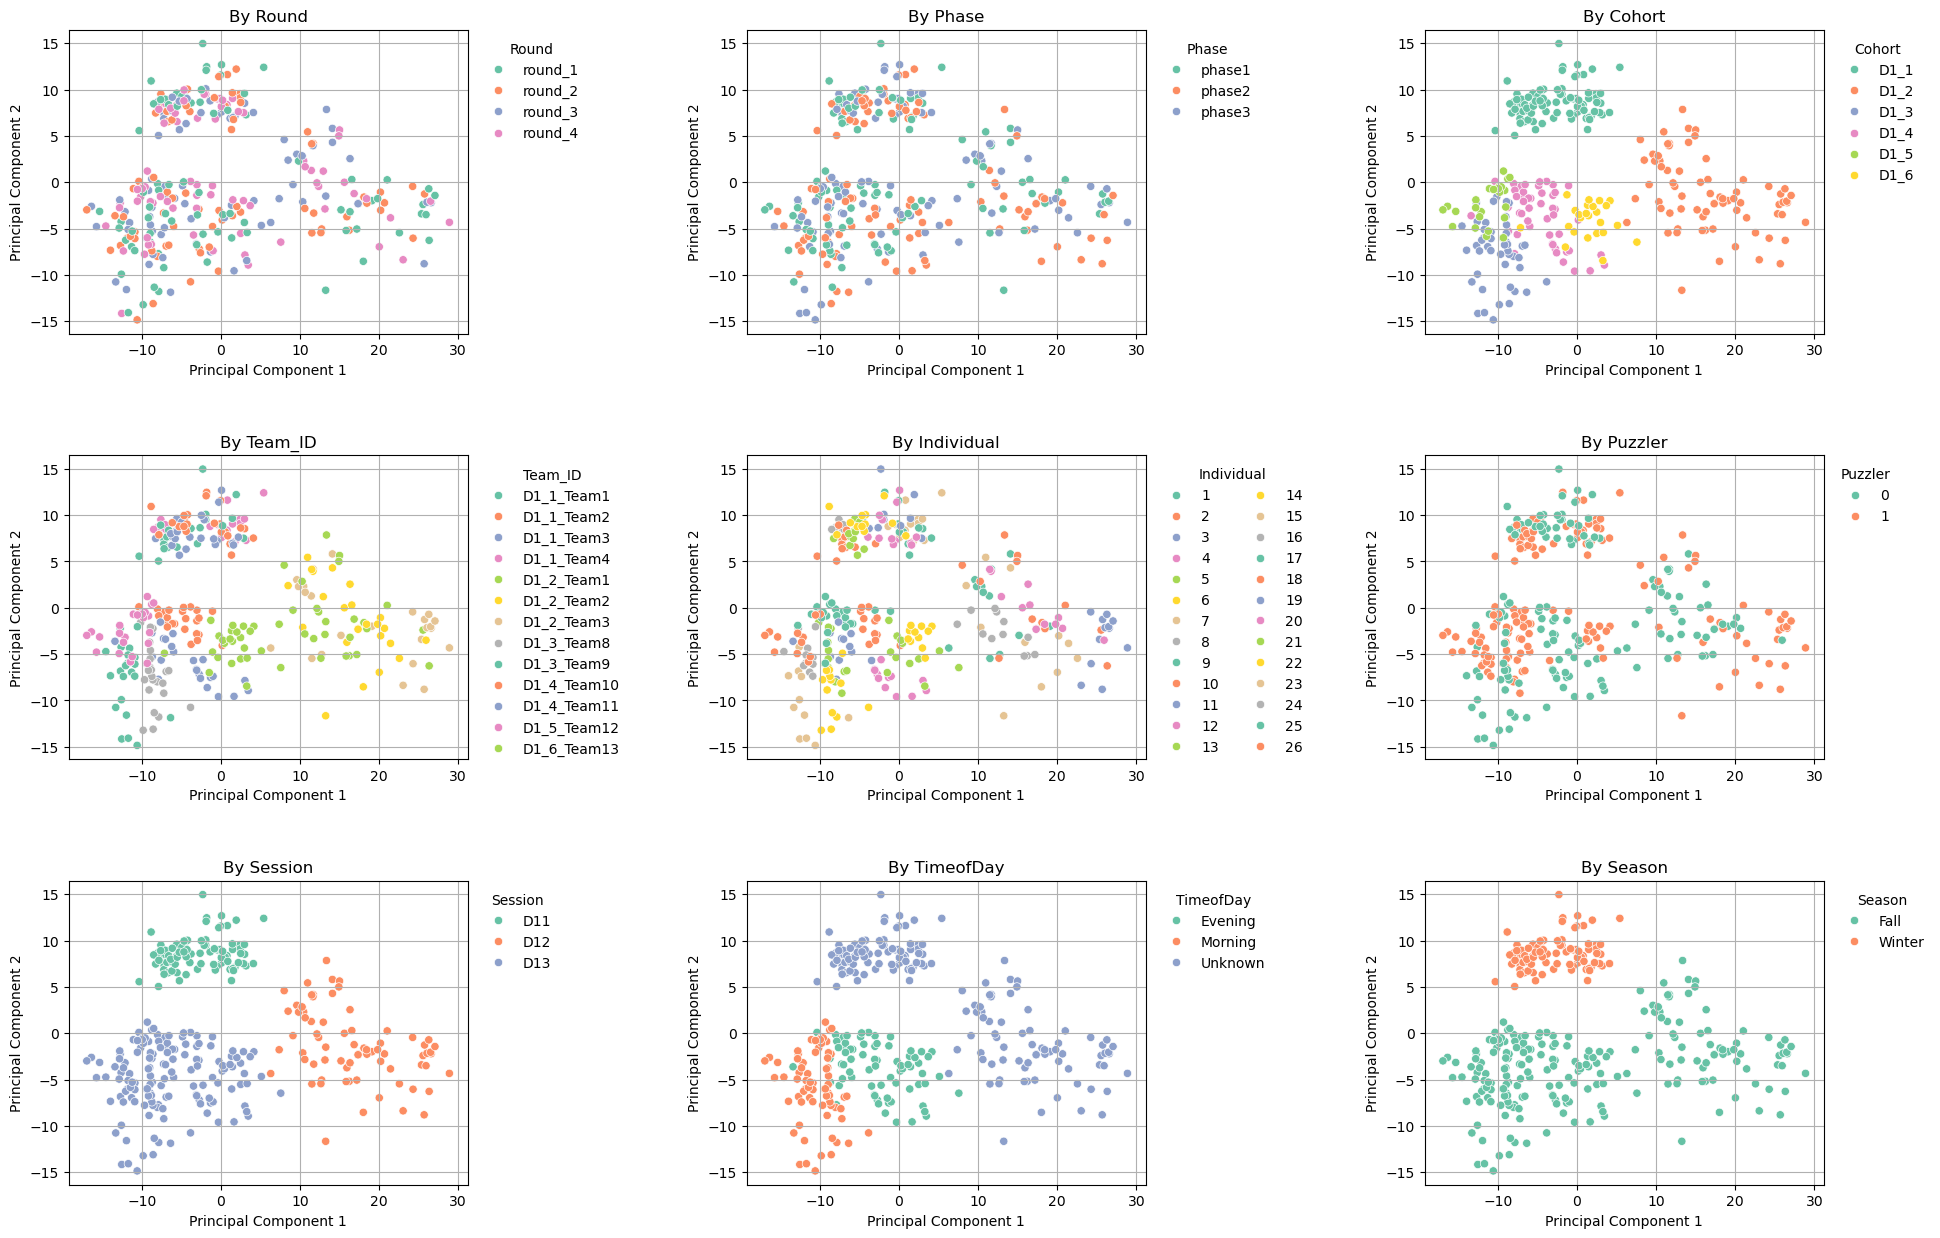

In [63]:
isomap = Isomap(n_neighbors = 30, n_components = 2)
isomap_components = isomap.fit_transform(standard_array)
isomap_df = pd.DataFrame(isomap_components, columns = ["PC 1", "PC 2"])
for t in categories:
    isomap_df[t] = data[t].values

# Set up 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(26, 15))
axes = axes.flatten()

for ax, t in zip(axes, categories):
    # grab the non-null values for this category
    series = isomap_df[t].dropna()
    
    # decide how to sort them:
    if pd.api.types.is_numeric_dtype(series):
        hue_order = sorted(series.unique())                     
    else:
        # numeric sort
        hue_order = sorted(series.astype(str).unique())         

    # draw the scatter with that explicit order
    sns.scatterplot(data = isomap_df, x = "PC 1", y = "PC 2", hue = t, palette = "Set2", hue_order = hue_order, ax = ax)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f"By {t}")
    ax.grid(True)

    # pull out the handles & labels in that order
    handles, labels = ax.get_legend_handles_labels()

    # place the legend
    if t == "Individual":
        ax.legend(handles, labels, title = "Individual", loc = "upper left", bbox_to_anchor = (1.01, 1), ncol = 2, frameon = False)
    else:
        ax.legend(handles, labels, title = t, loc = "upper left", bbox_to_anchor = (1.01, 1), frameon = False)

# Leave room on the right for all legends
fig.subplots_adjust(right = 0.80, wspace = 0.7, hspace = 0.4)

plt.show()



In [64]:
def sort_plot_order(levels):
    def keyfn(x):
        m = re.search(r"(\d+)$", str(x))
        return int(m.group(1)) if m else x
    return sorted(levels, key = keyfn)

def plot_by(df, split_cat, hue_cat, nrows = 1, ncols = None, figsize = (16, 5)):
    levels = sort_plot_order(df[split_cat].unique())
    n = len(levels)
    # default to 1×n if ncols not given
    if ncols is None:
        ncols = n
    
    # Create figure
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize, sharex = 'col', sharey = 'row')
    # flatten axes array
    axes = np.array(axes).reshape(-1)
    fig.suptitle(f"{split_cat} vs. {hue_cat}", fontsize = 16, y = 1.05)
    
    # draw each panel
    for i, lvl in enumerate(levels):
        ax = axes[i]
        subset = df[df[split_cat] == lvl]
        hue_series = subset[hue_cat].dropna()

        # numeric vs alpha sort
        if pd.api.types.is_numeric_dtype(hue_series):
            hue_order = sorted(hue_series.unique(), key=int)
        else:
            hue_order = sorted(hue_series.astype(str).unique())

        # only the last actual panel draws legend entries
        legend_mode = "brief" if i == n-1 else False
        
        sns.scatterplot(data = subset, x = "PC 1", y = "PC 2", hue = hue_cat, palette = "Set2", hue_order = hue_order,legend = legend_mode, ax = ax)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_title(str(lvl))
        ax.grid(True)
        
        # if this was the last axis, grab its handles+labels now
        if i == n-1:
            handles, labels = ax.get_legend_handles_labels()
            # then remove that axis's legend so it doesn't show twice
            ax.get_legend().remove()
            
    # hide any extra axes
    for j in range(n, nrows*ncols):
        axes[j].set_visible(False)
    
    # build a single legend from that last panel's handles/labels
    fig.legend(handles, labels, title = hue_cat, loc = "upper left", bbox_to_anchor = (0.005, 0.9))

    plt.show()



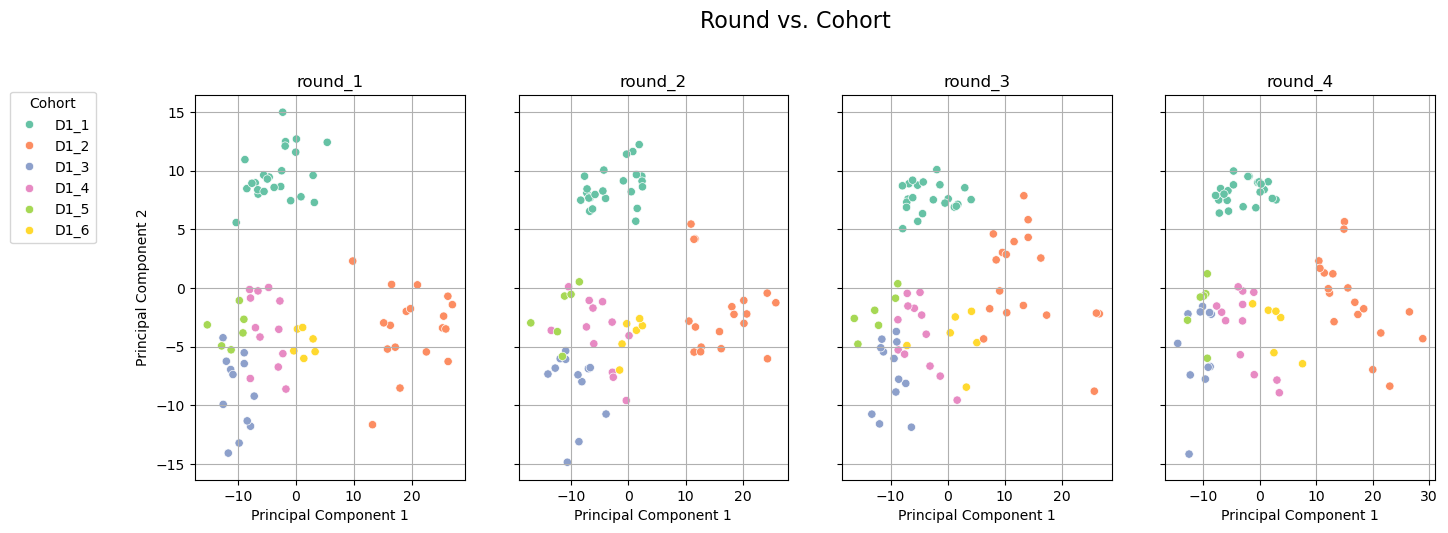

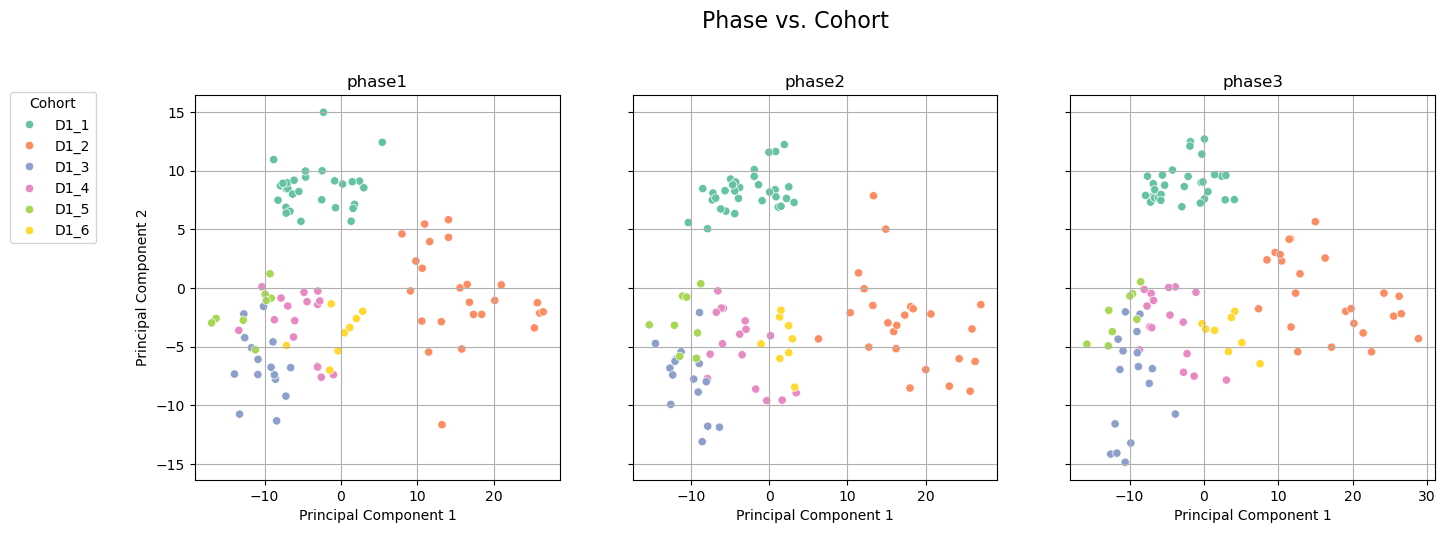

In [65]:
plot_by(isomap_df,'Round','Cohort') 
plot_by(isomap_df,'Phase','Cohort') 

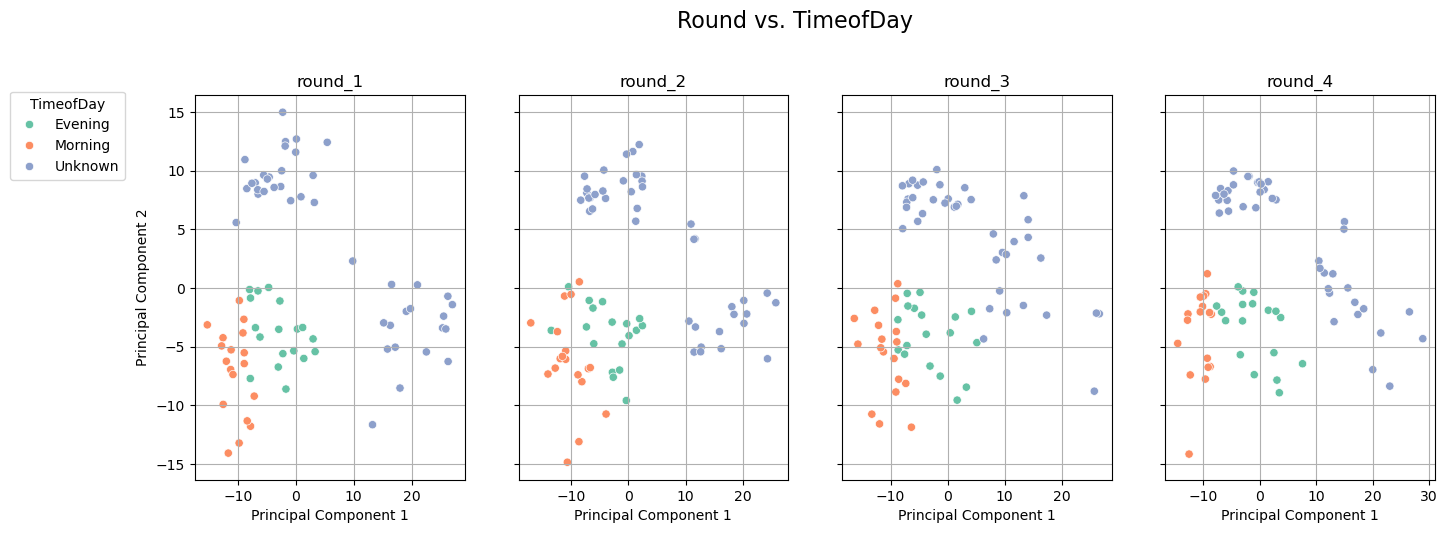

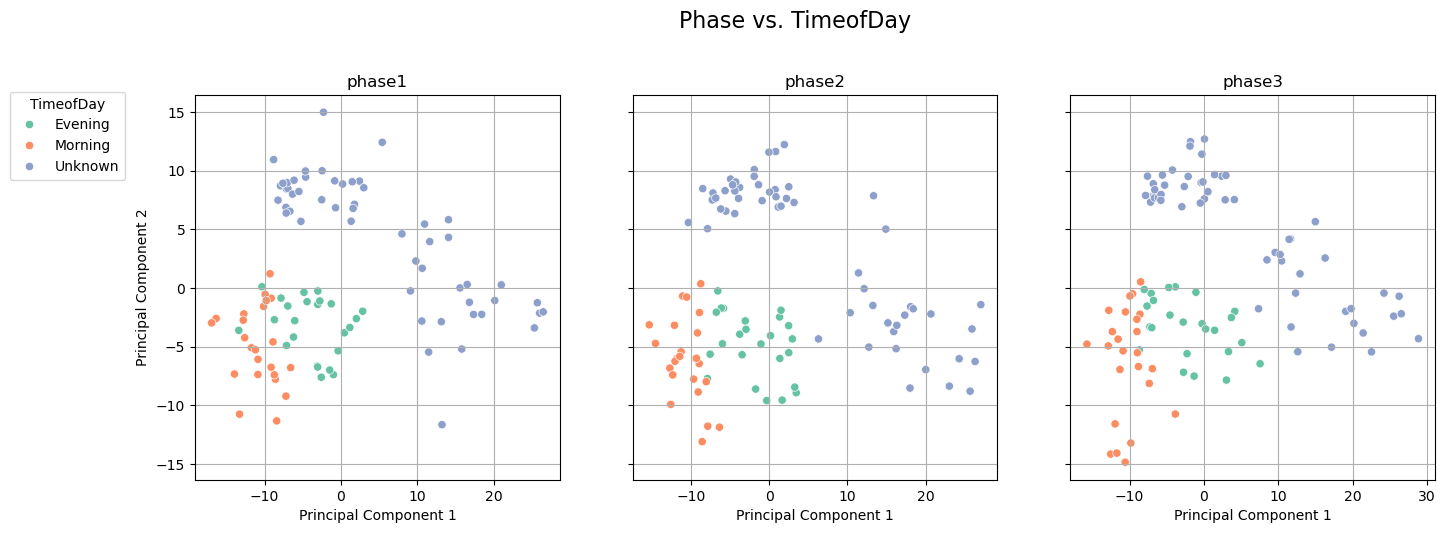

In [66]:
plot_by(isomap_df,'Round','TimeofDay') 
plot_by(isomap_df,'Phase','TimeofDay')

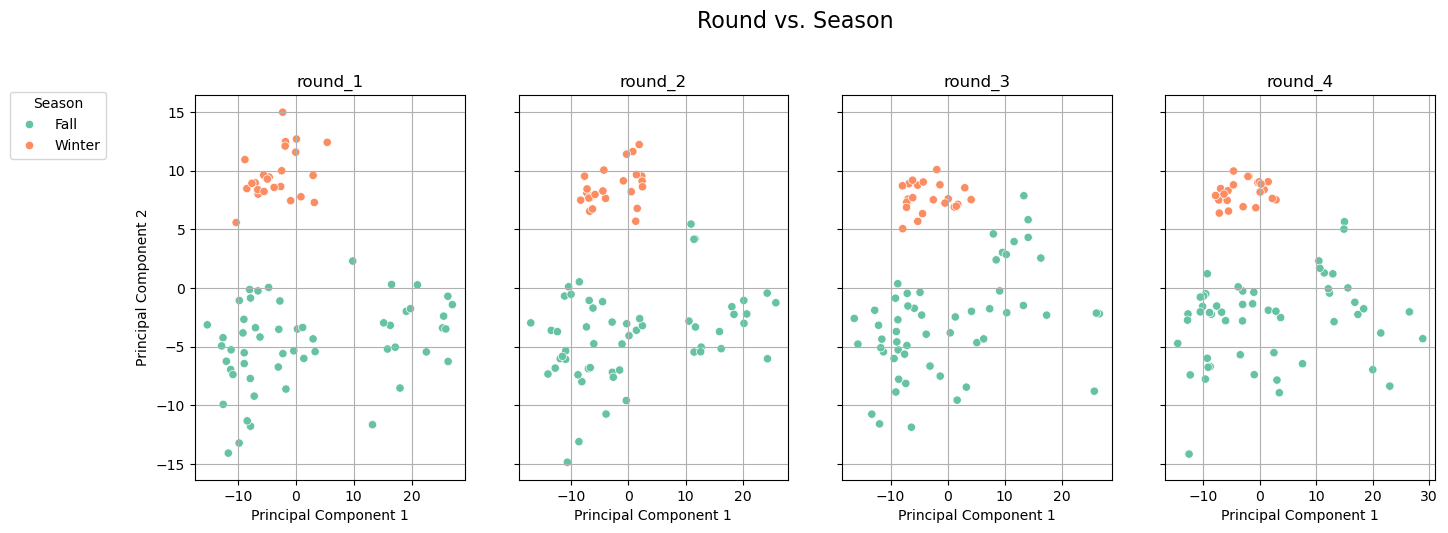

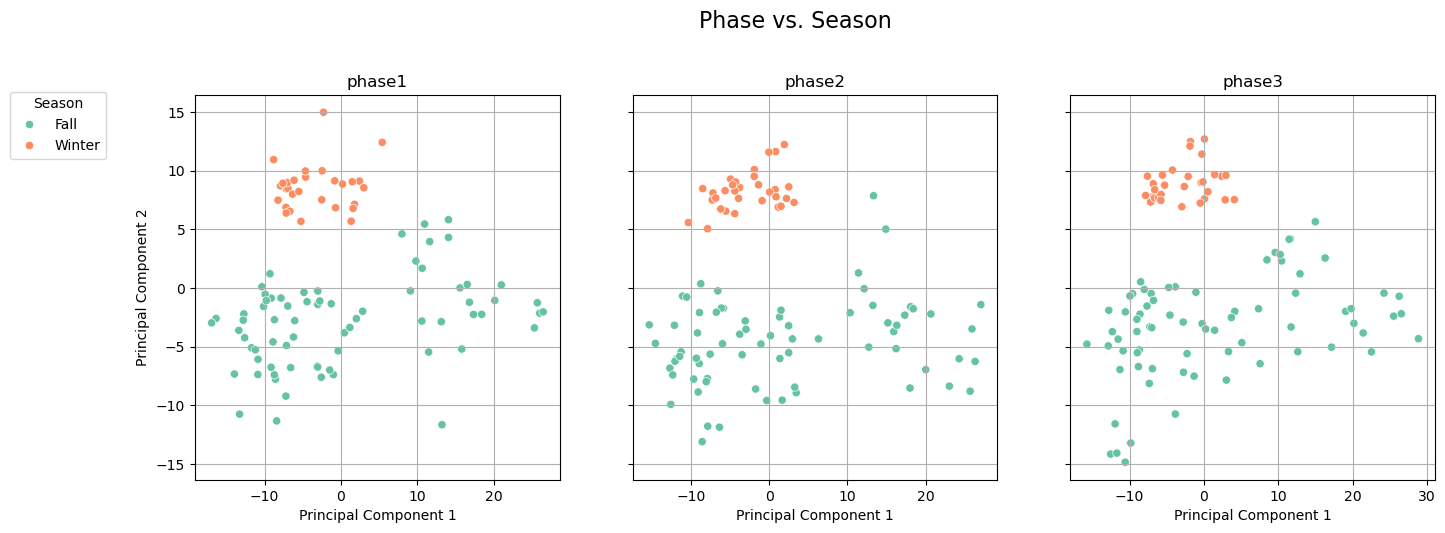

In [67]:
plot_by(isomap_df,'Round','Season')
plot_by(isomap_df,'Phase','Season') 

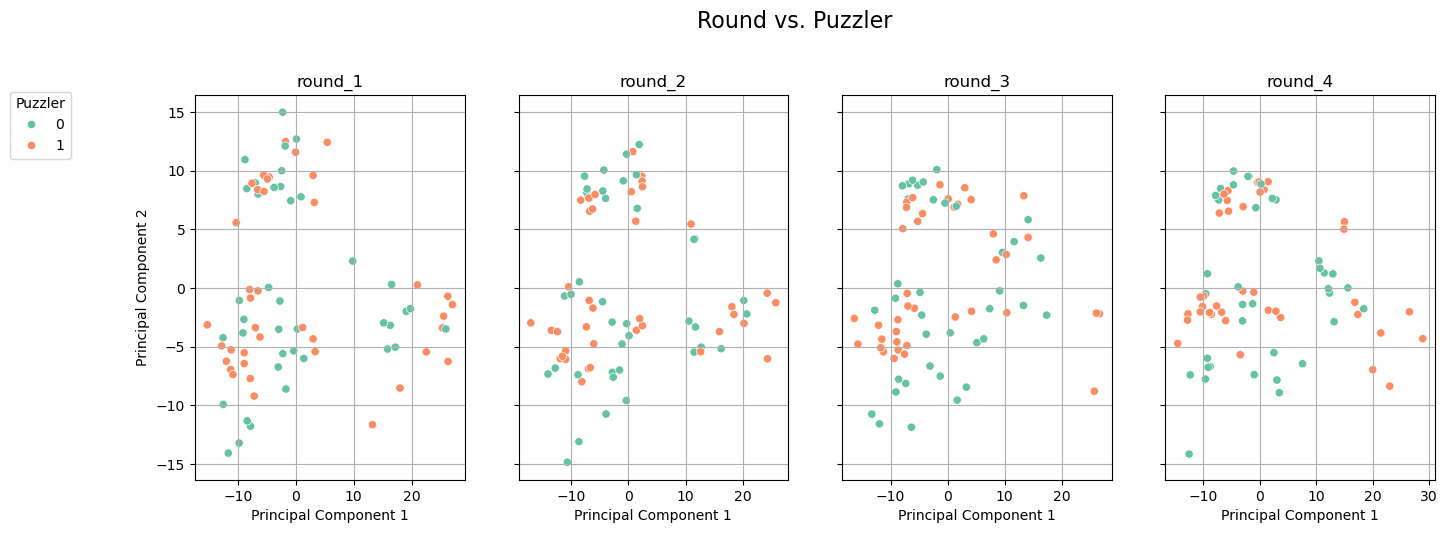

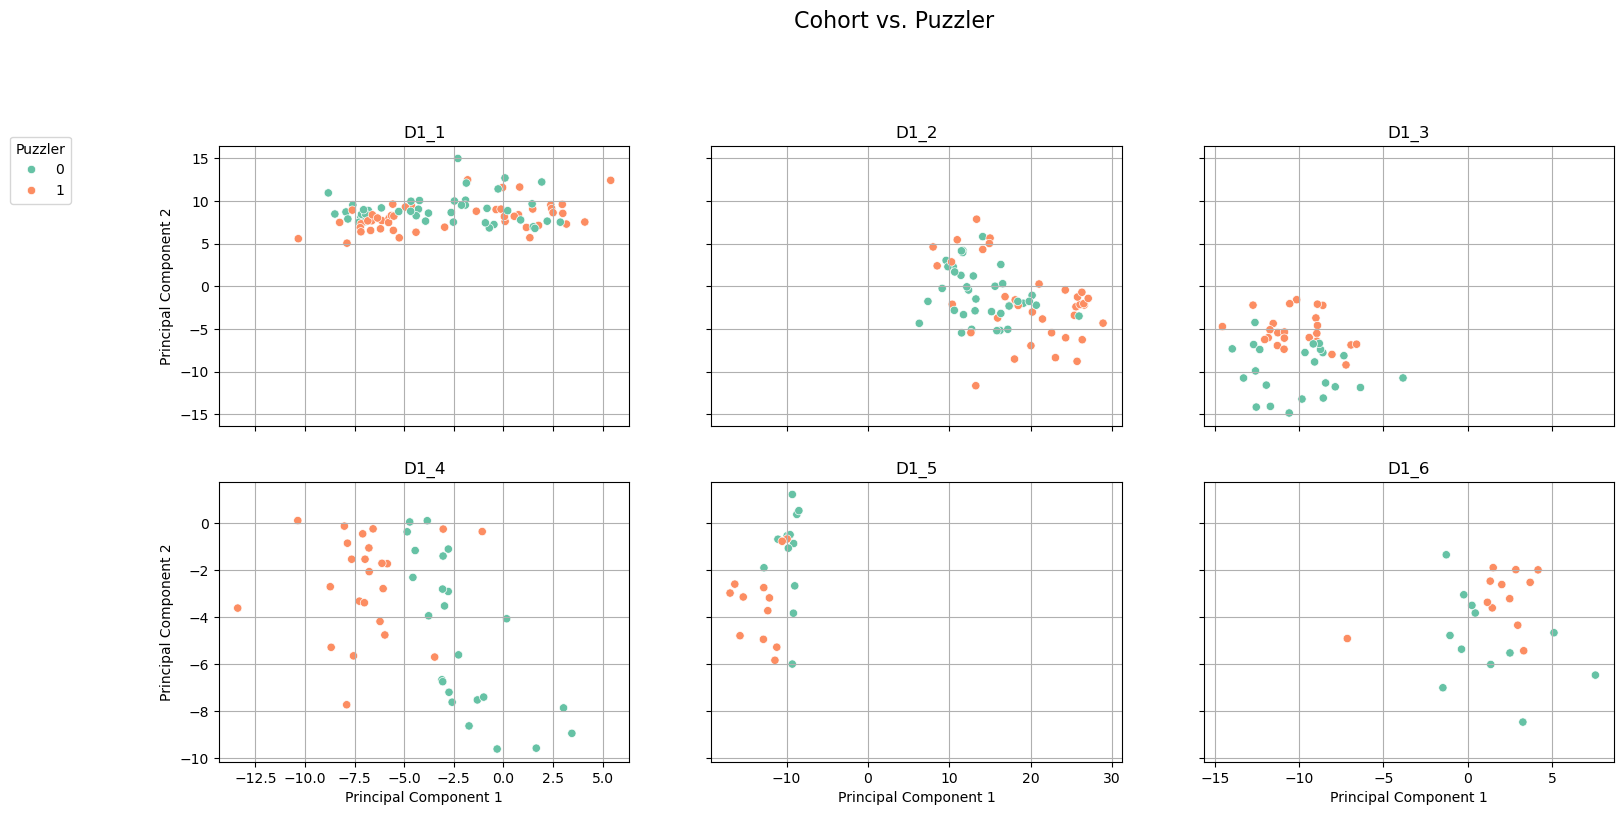

In [68]:
plot_by(isomap_df,'Round','Puzzler')
plot_by(isomap_df,'Cohort','Puzzler', nrows = 2, ncols = 3, figsize = (18, 8)) 

### K-medoids 
K-medoids use one of the observations as cluster center

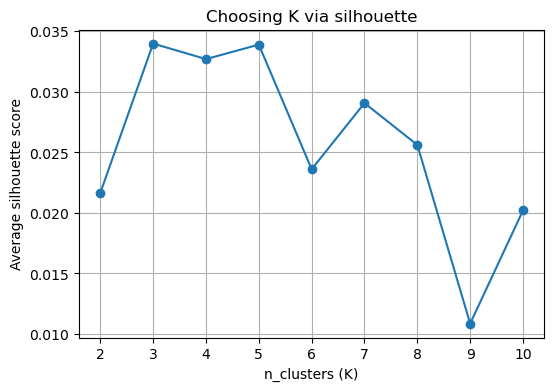

Best K by silhouette: 3


In [69]:
# Define the range of cluster numbers (K) to evaluate´
ks = range(2, 11)

# Initialize an empty list to store the average silhouette score for each K
sil_scores = []

# Loop over each candidate number of clusters
for k in ks:
    # Instantiate a KMedoids clustering model with k clusters and a fixed random seed
    km = KMedoids(n_clusters = k, random_state = 409)
    
    # Fit the model on the standardized data and predict cluster labels for each sample
    labels = km.fit_predict(standard_data)
    
    # Compute the average silhouette score for this clustering
    sil = silhouette_score(standard_data, labels)
    
    # Append the silhouette score to list
    sil_scores.append(sil)

# Create a new figure for the silhouette-vs-K plot
plt.figure(figsize = (6,4))

# Plot K values on the x-axis against their silhouette scores on the y-axis
plt.plot(ks, sil_scores, 'o-')

# Label the x-axis
plt.xlabel("n_clusters (K)")

# Label the y-axis
plt.ylabel("Average silhouette score")

# Give the plot a title
plt.title("Choosing K via silhouette")

# Add a grid for easier reading of the plot
plt.grid(True)

# Display the plot
plt.show()

# Identify which K gave the maximum silhouette score
best_k = ks[np.argmax(sil_scores)]

# Print out the best K
print(f"Best K by silhouette: {best_k}")

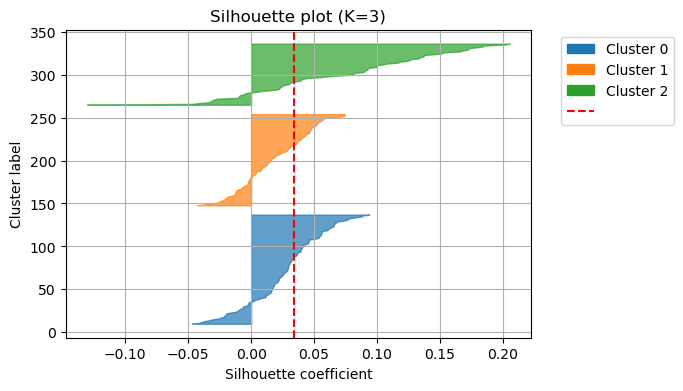

In [ ]:
# Instantiate the final KMedoids model using the previously selected best number of clusters
k_medoids = KMedoids(n_clusters = best_k, random_state = 409)

# Fit the model on the standardized data and obtain the cluster label for each sample
labels = k_medoids.fit_predict(standard_data)

# Compute the silhouette coefficient for each individual sample
sil_vals = silhouette_samples(standard_data, labels)

# Create figure
fig, ax1 = plt.subplots(1, 1, figsize = (6,4))

# Initialize the lower boundary for the plot’s vertical spacing
y_lower = 10

# Prepare legend patches for clusters
cluster_patches = []

# Loop over each cluster label
for i in range(best_k):

    # Select and sort the silhouette values that belong to the current cluster
    ith_sil = np.sort(sil_vals[labels == i])
    
    # Define the upper boundary for this cluster’s region in the plot
    y_upper = y_lower + len(ith_sil)
    
    # Choose a color for this cluster
    color = plt.cm.tab10(i)
    
    # Fill the silhouette band
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil, facecolor = color, edgecolor = color, alpha = 0.7)

    # Add a patch for the legend
    cluster_patches.append(mpatches.Patch(color = color, label = f"Cluster {i}"))
    
    # Update y_lower for the next cluster, adding a 10-point gap
    y_lower = y_upper + 10

# Compute the overall average silhouette score
avg_score = silhouette_score(standard_data, labels)

# Draw a vertical dashed red line
ax1.axvline(avg_score, color = "red", linestyle = "--")

# Add both cluster patches and the line to the legend
avg_line = Line2D([0], [0], color = 'red', linestyle = '--')

# Combine handles
handles = cluster_patches + [avg_line]
labels = [p.get_label() for p in handles]

# Place the legend outside the plot on the right
ax1.legend(handles, labels, bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Label the axes
ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")
# Set the title
ax1.set_title(f"Silhouette plot (K={best_k})")
# Add a grid 
ax1.grid(True)

plt.show()


### Hierarchical clustering

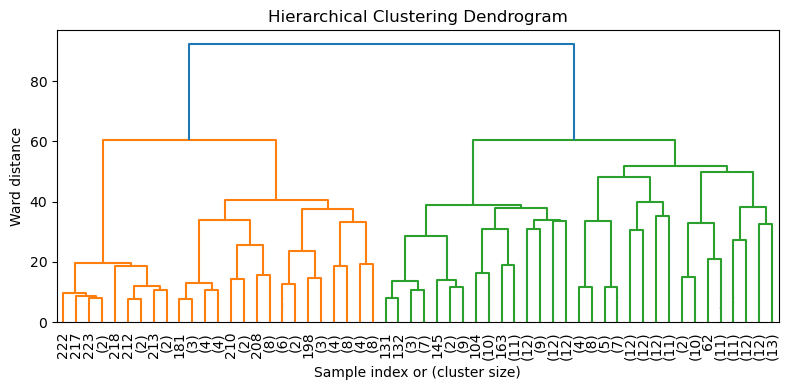

Average silhouette score (K = 3): 0.079
Cluster sizes: {1: 72, 2: 92, 3: 143}


In [ ]:
# Compute the hierarchical linkage matrix (Ward’s method)
Z = linkage(standard_data, method = 'ward')

# Plot the dendrogram (truncated)
# show only the top levels and choose how many levels to show by p = 5
plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode='level',  p = 5, leaf_rotation = 90, leaf_font_size = 10, show_contracted = True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Ward distance")
plt.tight_layout()
plt.show()

# Cut the tree to form a flat clustering with K clusters
labels = fcluster(Z, t = best_k, criterion = 'maxclust')

# Evaluate clustering quality via silhouette score
sil_avg = silhouette_score(standard_data, labels)
print(f"Average silhouette score (K = {best_k}): {sil_avg:.3f}")

# Inspect cluster sizes
unique, counts = np.unique(labels, return_counts = True)
print("Cluster sizes:", dict(zip(unique, counts)))


### Complete-linkage hierarchical clustering

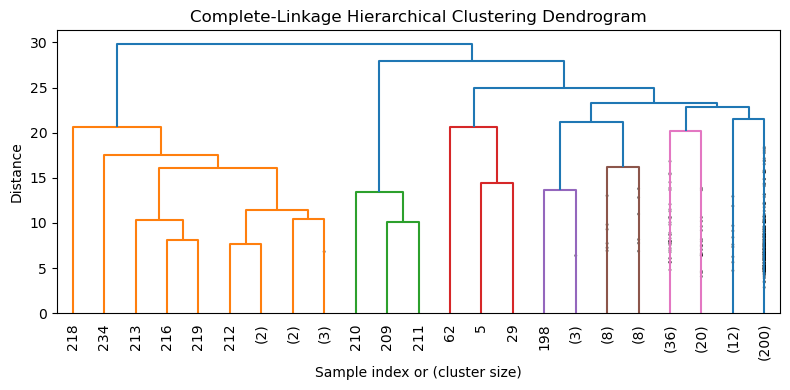

Average silhouette score (complete-linkage, K = 3): 0.289
Best K by silhouette (complete linkage): 2


In [80]:
# Compute the complete‐linkage hierarchical clustering
Z_complete = linkage(standard_data, method = 'complete')

# 3) Plot the (truncated) dendrogram
plt.figure(figsize=(8,4))
dendrogram(Z_complete, truncate_mode = 'level', p = 5, leaf_rotation = 90, leaf_font_size = 10, show_contracted = True)
plt.title("Complete-Linkage Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Cut the tree to get flat clusters for the best K
K = labels_complete = fcluster(Z_complete, t = best_k, criterion = 'maxclust')

# 5) Evaluate with silhouette score
sil_avg = silhouette_score(standard_data, labels_complete)
print(f"Average silhouette score (complete-linkage, K = {best_k}): {sil_avg:.3f}")

# 6) (Optional) find best K by sweeping with silhouette
sil_scores = []
for k in range(2, 11):
    lbls = fcluster(Z_complete, t = k, criterion = 'maxclust')
    sil_scores.append(silhouette_score(standard_array, lbls))
best_k = np.arange(2,11)[np.argmax(sil_scores)]
print("Best K by silhouette (complete linkage):", best_k)

### Gaussian mixture models

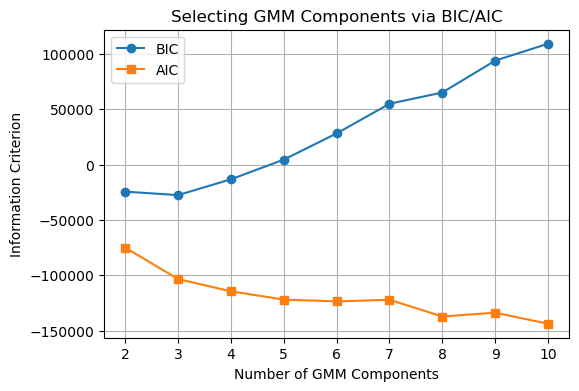

Optimal number of components by BIC: 3
Cluster weights: [0.238 0.463 0.3  ]
Cluster means (first two features shown):
 [[-0.234 -0.219]
 [ 0.256  0.252]
 [-0.21  -0.216]]
Covariance type: full


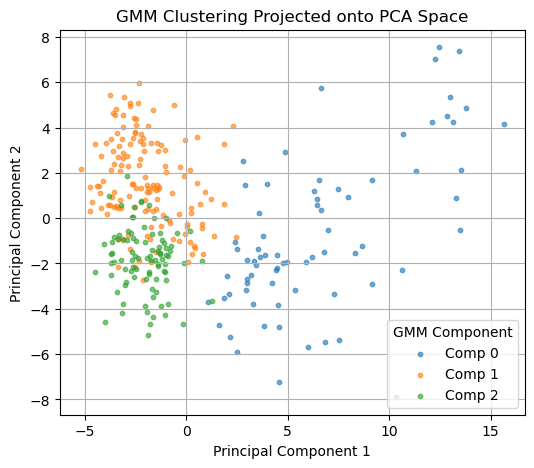

In [85]:
from sklearn.mixture import GaussianMixture

# Record BIC & AIC for a number of components
n_components = np.arange(2, 11)
bics = []
aics = []
for n in n_components:
    gmm = GaussianMixture(n_components = n, covariance_type = 'full', random_state = 409)
    gmm.fit(standard_data)
    bics.append(gmm.bic(standard_data))
    aics.append(gmm.aic(standard_data))

# 5) Plot BIC and AIC vs. number of components
plt.figure(figsize = (6,4))
plt.plot(n_components, bics, label = 'BIC', marker = 'o')
plt.plot(n_components, aics, label = 'AIC', marker = 's')
plt.xlabel("Number of GMM Components")
plt.ylabel("Information Criterion")
plt.title("Selecting GMM Components via BIC/AIC")
plt.legend()
plt.grid(True)
plt.show()

# 6) Choose the model with lowest BIC
best_n = n_components[np.argmin(bics)]
print(f"Optimal number of components by BIC: {best_n}")

# 7) Fit the final GMM
gmm_final = GaussianMixture(n_components = best_n, covariance_type = 'full', random_state = 409)
# cluster assignment for each sample
labels = gmm_final.fit_predict(standard_data)   
# responsibilities (soft assignments) 
probs  = gmm_final.predict_proba(standard_data)  

# 8) Inspect the GMM parameters
print("Cluster weights:", np.round(gmm_final.weights_, 3))
print("Cluster means (first two features shown):\n", np.round(gmm_final.means_[:, :2], 3))
print("Covariance type:", gmm_final.covariance_type)

#  Visualize clustering on first two principal components
pca = PCA(n_components = 2)
X2 = pca.fit_transform(standard_data)

plt.figure(figsize = (6,5))
for k in range(best_n):
    idx = (labels == k)
    plt.scatter(X2[idx, 0], X2[idx, 1], s = 10, alpha = 0.6, label = f"Comp {k}")
plt.legend(title = "GMM Component")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clustering Projected onto PCA Space")
plt.grid(True)
plt.show()

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA()   
scores = pca.fit_transform(standard_data)

# Build PC names
pc_names = [f"PC {i+1}" for i in range(pca.n_components_)]

# Columns of S are the principal components (PC)
scores_df = pd.DataFrame(scores, columns = pc_names, index = standard_data.index)

# Columns of L are known as the principal axes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print("loadings.shape:", loadings.shape)

loadings_df = pd.DataFrame(loadings, index = standard_data.columns, columns = pc_names)

print("\nSCORES (first 5 rows):\n", scores_df.iloc[:5, :4])
print("\nLOADINGS (first 5 rows):\n", loadings_df.iloc[:5, :4])

loadings.shape: (115, 115)

SCORES (first 5 rows):
        PC 1      PC 2      PC 3      PC 4
0 -3.459879  0.526956  0.086591 -1.158488
1 -3.562602  0.477645 -0.280226  0.465830
2 -4.235562  0.442297 -0.932560 -0.805127
3 -3.866951  0.583354  0.012838  0.184317
4 -4.098023  1.627990 -0.434235  1.638995

LOADINGS (first 5 rows):
                   PC 1      PC 2      PC 3      PC 4
HR_TD_Mean   -0.061743  0.596550 -0.006950  0.131279
HR_TD_Median -0.043852  0.565175 -0.033789  0.116637
HR_TD_std    -0.106541  0.347395  0.179345  0.071718
HR_TD_Min     0.007935  0.394700 -0.131838  0.105835
HR_TD_Max    -0.104775  0.533941  0.107361  0.132356


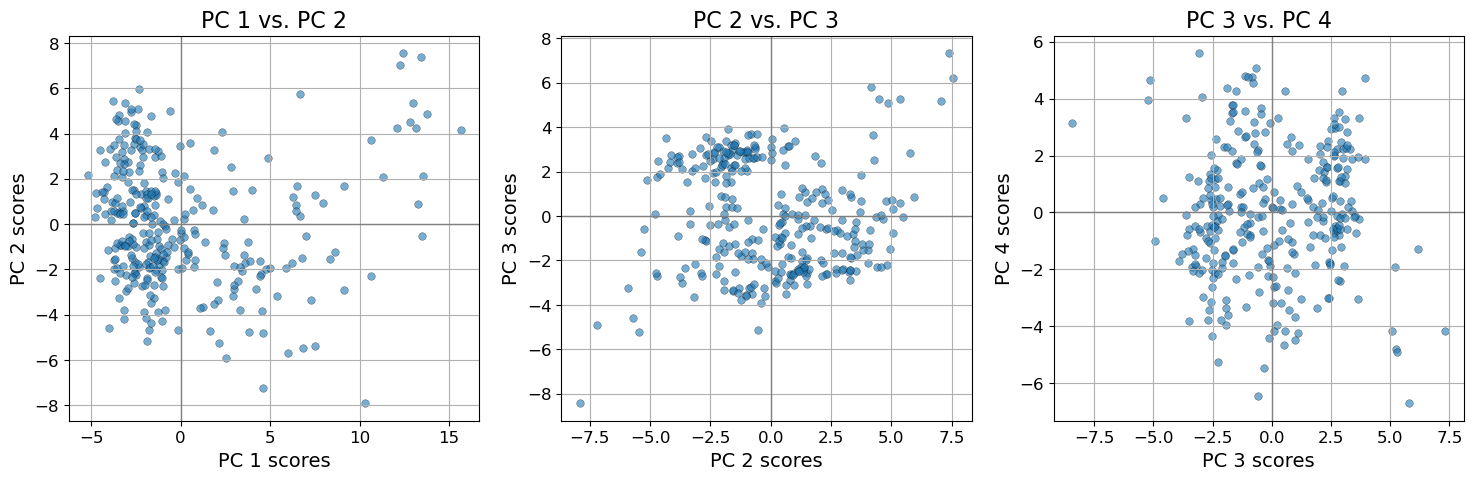

In [ ]:
# Set up 1×3 grid
pairs = [(1, 2), (2, 3), (3, 4)]
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

# Loop through principal components
for ax, (i, j) in zip(axes, pairs):
    xcol, ycol = f"PC {i}", f"PC {j}"
    
    # scatter plots
    ax.scatter(scores_df[xcol], scores_df[ycol], alpha = 0.6, s = 30, edgecolor = 'k', linewidth = 0.3)
    ax.set_xlabel(f"{xcol} scores", fontsize = 14)
    ax.set_ylabel(f"{ycol} scores", fontsize = 14)
    ax.set_title(f"{xcol} vs. {ycol}", fontsize = 16)
    ax.xaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_tick_params(labelsize = 12)
    ax.axhline(0, color = "gray", linewidth = 1)
    ax.axvline(0, color = "gray", linewidth = 1)
    ax.grid(True)

plt.show()

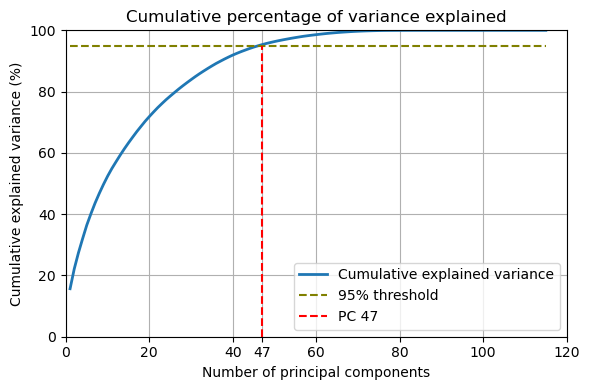

In [ ]:
# Cumulative percentage of variance explained
explained_pct = pca.explained_variance_ratio_ * 100 
cum_ev = np.cumsum(explained_pct)

# first PC index reaching ≥95%
threshold = 95
comp95 = np.argmax(cum_ev >= threshold) + 1  

plt.figure(figsize = (6, 4))
plt.plot(np.arange(1, len(explained_pct)+1), cum_ev, lw = 2, label = "Cumulative explained variance")

# horizontal dashed line at 95%
plt.hlines(threshold, 1, len(explained_pct), colors = 'olive', linestyles = '--', label = f"{threshold}% threshold")

# vertical dashed line at the component index
plt.vlines(comp95, 0, threshold, colors = 'red', linestyles = '--', label = f"PC {comp95}")

plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("Cumulative percentage of variance explained")

plt.ylim(0, 100)
plt.xlim(1, len(explained_pct))
plt.grid(True)

# ensure the tick component that reached 95% explained variance first is shown
xticks = list(plt.xticks()[0])
if comp95 not in xticks:
    xticks.append(comp95)
    xticks.sort()
plt.xticks(xticks)

plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

#### For the next plot regarding loadings:

- Variables close to each other far away from origin (0,0) are correlated.

- Variables close to (0,0) are not explained by the chosen principal components and not much can be concluded.

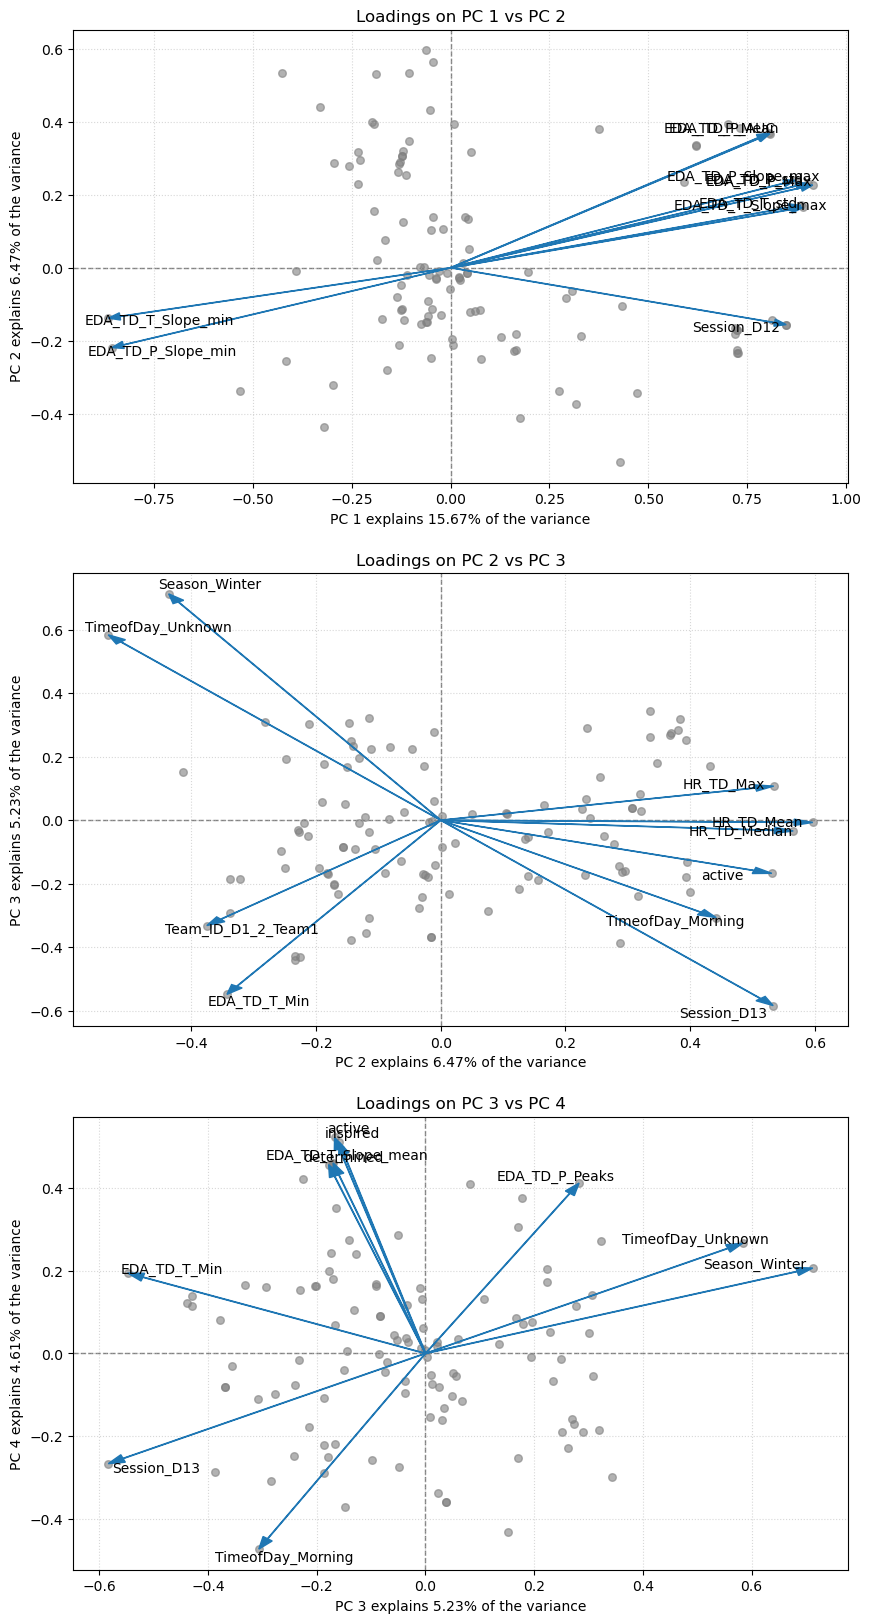

In [ ]:
pairs = [(1,2), (2,3), (3,4)]
fig, axes = plt.subplots(3, 1, figsize = (10, 20))

# only label the top 10 loadings by absolute value
topK = 10  

for ax, (i, j) in zip(axes, pairs):
    xcol = f"PC {i}"
    ycol = f"PC {j}"
    
    # scatter the loading points
    ax.scatter(loadings_df[xcol], loadings_df[ycol], s = 30, color = "gray", alpha = 0.6, zorder = 1)

    # pick the TOP_K by absolute loading magnitude
    mag = (loadings_df[xcol]**2 + loadings_df[ycol]**2)**0.5
    top_idx = mag.nlargest(topK).index
    
    # annotate each variable
    for var in top_idx:
        x, y = loadings_df.loc[var, [xcol, ycol]]
        ax.arrow(0, 0, x, y, color = "C0", head_width = 0.02, length_includes_head = True, zorder = 3)
        ax.text(x*0.85, y*1.04, var, ha = "center", va = "center", fontsize = 10,
            bbox = dict(boxstyle = "round,pad=0.2", fc = "none", ec = "none", alpha = 0.7), zorder = 4)
        
    
    # dashed zero‐lines
    ax.axhline(0, color = "gray", linestyle = "--", linewidth = 1, zorder = 1)
    ax.axvline(0, color = "gray", linestyle = "--", linewidth = 1, zorder = 1)
    
    # axis labels with % variance
    ax.set_xlabel(f"{xcol} explains {explained_pct[i-1]:.2f}% of the variance")
    ax.set_ylabel(f"{ycol} explains {explained_pct[j-1]:.2f}% of the variance")
    ax.set_title(f"Loadings on {xcol} vs {ycol}")
    ax.grid(True, linestyle = ":", alpha = 0.5)
    
plt.show()